In [4]:
%matplotlib inline

In [7]:
#format the book
import book_format
book_format.set_style()

如果您已经走到了这一步，我希望您认为卡尔曼滤波器的可怕声誉有些不应该。当然，我放弃了一些方程式，但我希望实现对你来说相当简单。基本概念非常简单——进行两次测量，或一次测量和一次预测，然后选择介于两者之间的输出。如果您更相信测量值，您的猜测将更接近测量值，如果您相信预测更准确，您的猜测将更接近它。那不是火箭科学（开个小玩笑——正是这个数学让阿波罗登月并返回！）。

老实说，我一直在仔细选择我的问题。对于任意问题，设计卡尔曼滤波器矩阵可能非常困难。不过，我并没有*太棘手*。像牛顿运动方程这样的方程可以很容易地为卡尔曼滤波器应用计算，它们构成了我们想要解决的大部分问题。

我用代码和推理来说明这些概念，而不是数学。但是有些主题确实需要比我迄今为止使用的更多的数学知识。本章介绍了本书其余部分所需的数学知识。

## Modeling a Dynamic System

*动态系统*是其状态（位置、温度等）随时间演变的物理系统。微积分是变化值的数学，所以我们使用微分方程来模拟动态系统。有些系统不能用微分方程建模，但我们不会在本书中遇到这些。

动态系统建模是几门大学课程的主题。在某种程度上，没有什么可以替代几个学期的常微分方程和偏微分方程，然后是控制系统理论的研究生课程。如果你是一个业余爱好者，或者试图在工作中解决一个非常具体的过滤问题，你可能没有时间和/或意愿投入一年或更多的时间来接受这种教育。

幸运的是，我可以提供足够多的理论来让我们为许多不同的卡尔曼滤波器创建系统方程。我的目标是让您进入可以阅读出版物并充分理解它以实现算法的阶段。背景数学很深，但在实践中，我们最终会使用一些简单的技术。

这是本书中最长的纯数学部分。您需要掌握本节中的所有内容才能理解扩展卡尔曼滤波器 (EKF)，这是最常见的非线性滤波器。我确实涵盖了不需要那么多数学的更现代的过滤器。您现在可以选择略读，如果您决定学习 EKF，请返回此内容。

我们需要首先了解卡尔曼滤波器使用的基本方程和假设。我们正在尝试对现实世界的现象进行建模，那么我们必须考虑什么？

每个物理系统都有一个进程。例如，一辆以一定速度行驶的汽车在固定的时间内行驶这么远，它的速度随着它的加速度而变化。我们用我们在高中学到的众所周知的牛顿方程来描述这种行为。

$$
\begin{aligned}
v&=at\\
x &= \frac{1}{2}at^2 + v_0t + x_0
\end{aligned}
$$

根据微积分数学知识，我们会得到：

$$ \mathbf v = \frac{d \mathbf x}{d t}, 
\quad \mathbf a = \frac{d \mathbf v}{d t} = \frac{d^2 \mathbf x}{d t^2}
$$

除了最琐碎的问题之外，完美地对系统建模是不可能的。 我们被迫做一个简化。 在任何时间 $t$ 我们都说真实状态（例如我们汽车的位置）是来自不完美模型的预测值加上一些未知的*过程噪声*：

$$
x(t) = x_{pred}(t) + noise(t)
$$

在下一节中，我们将学习将一组高阶微分方程转换为一组一阶微分方程的技术。 转换后的无噪声系统模型为：
$$ \dot{\mathbf x} = \mathbf{Ax}$$

$\mathbf A$ 被称为*系统动力学矩阵*，因为它描述了系统的动力学。 现在我们需要对噪声进行建模。 我们将称其为 $\mathbf w$，并将其添加到等式中
$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf w$$

$\mathbf w$ 可能会让你觉得这个名字是一个糟糕的选择，但你很快就会看到卡尔曼滤波器假设*白*噪声。

最后，我们需要考虑系统的任何输入。 我们假设一个输入 𝐮 ，并且存在一个线性模型来定义该输入如何改变系统。 例如，按下汽车中的加速器会使其加速，而重力会导致球下落。 两者都是控制输入。 我们需要一个矩阵 𝐁 来将 𝑢 转换为对系统的影响。 我们将其添加到我们的等式中：

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

## State-Space Representation of Dynamic Systems
我们已经推导出方程
$$ \dot{\mathbf x} = \mathbf{Ax}+ \mathbf{Bu} + \mathbf{w}$$

然而，我们对 $\mathbf x$ 的导数不感兴趣，而对 $\mathbf x$ 本身感兴趣。 暂时忽略噪音，我们需要一个方程，根据时间 $t_{k-1}$ 处的 $\mathbf x$ 递归地求出时间 $t_k$ 处的 $\mathbf x$ 值：
$$\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1}) + \mathbf B(t_k)\mathbf u (t_k)$$

约定允许我们将 $\mathbf x(t_k)$ 写成 $\mathbf x_k$，这意味着
$\mathbf x$ 在 $t$ 的 k$^{th}$ 值处的值。
$$\mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

$\mathbf F$ 是熟悉的*状态转换矩阵*，因其能够在离散时间步之间转换状态值而得名。 它与系统动力学矩阵 $\mathbf A$ 非常相似。 不同之处在于$\mathbf A$ 对一组线性微分方程进行建模，并且是连续的。 $\mathbf F$ 是离散的，表示一组线性方程（不是微分方程），它在离散时间步 $\Delta t$ 上将 $\mathbf x_{k-1}$ 转换为 $\mathbf x_k$。

找到这个矩阵通常非常困难。 方程 $\dot x = v$ 是最简单的微分方程，我们将它简单地积分为：

$$ \int\limits_{x_{k-1}}^{x_k}  \mathrm{d}x = \int\limits_{0}^{\Delta t} v\, \mathrm{d}t $$
$$x_k-x_0 = v \Delta t$$
$$x_k = v \Delta t + x_0$$

这个方程是*递归的*：我们根据它在时间 $t-1$ 的值计算 $x$ 在时间 $t$ 的值。 这种递归形式使我们能够以卡尔曼滤波器所需的形式表示系统（过程模型）：

$$\begin{aligned}
\mathbf x_k &= \mathbf{Fx}_{k-1}  \\
&= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}
\begin{bmatrix}x_{k-1} \\ \dot x_{k-1}\end{bmatrix}
\end{aligned}$$

我们可以这样做只是因为 $\dot x = v$ 是可能的最简单微分方程。 几乎所有其他物理系统都导致更复杂的微分方程不屈服于这种方法。

*状态空间*方法在阿波罗任务期间开始流行，主要是由于卡尔曼博士的工作。 这个想法很简单。 用一组 $n^{th}$ 阶微分方程对系统建模。 将它们转换为一组等效的一阶微分方程。 将它们放入上一节中使用的向量矩阵形式：$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu}$。 一旦采用这种形式，我们使用几种技术将这些线性微分方程转换为递归方程：

$$ \mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

有些书将状态转移矩阵称为*基本矩阵*。 许多人使用 $\mathbf \Phi$ 而不是 $\mathbf F$。 大量基于控制理论的资料倾向于使用这些形式。
这些被称为*状态空间*方法，因为我们用系统状态来表达微分方程的解。

### Forming First Order Equations from Higher Order Equations

许多物理系统模型需要具有控制输入 $u$ 的二阶或更高阶微分方程：

$$a_n \frac{d^ny}{dt^n} + a_{n-1} \frac{d^{n-1}y}{dt^{n-1}} +  \dots + a_2 \frac{d^2y}{dt^2} + a_1 \frac{dy}{dt} + a_0 = u$$

状态空间方法需要一阶方程。 任何高阶方程组都可以通过为导数定义额外变量然后求解来简化为一阶。


让我们做一个例子。 给定系统 $\ddot{x} - 6\dot x + 9x = u$ 找到等效的一阶方程。 为了清楚起见，我使用点符号表示时间导数。

第一步是将最高阶项隔离到等式的一侧。

$$\ddot{x} = 6\dot x - 9x + u$$

我们定义了两个新变量：

$$\begin{aligned} x_1(u) &= x \\
x_2(u) &= \dot x
\end{aligned}$$

现在我们将这些代入原始方程并求解。 该解根据这些新变量产生一组一阶方程。 为方便起见，通常会删除 $(u)$。

我们知道 $\dot x_1 = x_2$ 和 $\dot x_2 = \ddot{x}$。 所以

$$
\begin{aligned}
\dot x_2 &= \ddot{x} \\
         &= 6\dot x - 9x + t\\
         &= 6x_2-9x_1 + t
\end{aligned}
$$

因此我们的一阶方程组是

$$\begin{aligned}\dot x_1 &= x_2 \\
\dot x_2 &= 6x_2-9x_1 + t\end{aligned}$$

如果你稍微练习一下，你就会熟练掌握它。 隔离最高项，定义一个新变量及其导数，然后替换。

### First Order Differential Equations In State-Space Form

替换上一节中新定义的变量：

$$\frac{dx_1}{dt} = x_2,\,  
\frac{dx_2}{dt} = x_3, \, ..., \, 
\frac{dx_{n-1}}{dt} = x_n$$

一阶方程得到：

$$\frac{dx_n}{dt} = \frac{1}{a_n}\sum\limits_{i=0}^{n-1}a_ix_{i+1} + \frac{1}{a_n}u
$$

使用向量矩阵表示法，我们有：

$$\begin{bmatrix}\frac{dx_1}{dt} \\ \frac{dx_2}{dt} \\ \vdots \\ \frac{dx_n}{dt}\end{bmatrix} = 
\begin{bmatrix}\dot x_1 \\ \dot x_2 \\ \vdots \\ \dot x_n\end{bmatrix}=
\begin{bmatrix}0 & 1 & 0 &\cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
-\frac{a_0}{a_n} & -\frac{a_1}{a_n} & -\frac{a_2}{a_n} & \cdots & -\frac{a_{n-1}}{a_n}\end{bmatrix}
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix} + 
\begin{bmatrix}0 \\ 0 \\ \vdots \\ \frac{1}{a_n}\end{bmatrix}u$$

然后我们写成 $\dot{\mathbf x} = \mathbf{Ax} + \mathbf{B}u$.

### Finding the Fundamental Matrix for Time Invariant Systems

我们用状态空间形式表示系统方程

$$ \dot{\mathbf x} = \mathbf{Ax}$$

其中 $\mathbf A$ 是系统动力学矩阵，并且想要找到*基本矩阵* $\mathbf F$ 在区间 $\Delta t$ 上传播状态 $\mathbf x$ 与方程

$$\begin{aligned}
\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1})\end{aligned}$$

换句话说，$\mathbf A$ 是一组连续微分方程，我们需要 $\mathbf F$ 是一组离散线性方程组，用于计算在离散时间步长上 $\mathbf A$ 的变化。

按照惯例，去掉 $t_k$ 和 $(\Delta t)$ 并使用符号

$$\mathbf x_k = \mathbf {Fx}_{k-1}$$

一般来说，有三种常见的方法可以找到卡尔曼滤波器的这个矩阵。 最常用的技术是矩阵指数。 线性时不变理论，也称为 LTI 系统理论，是第二种技术。 最后，还有数值技术。 您可能知道其他人，但这三个是您在卡尔曼滤波器文献和实践中最有可能遇到的。

### The Matrix Exponential

方程 $\frac{dx}{dt} = kx$ 的解可以通过以下方式找到：

$$\begin{gathered}\frac{dx}{dt} = kx \\
\frac{dx}{x} = k\, dt \\
\int \frac{1}{x}\, dx = \int k\, dt \\
\log x = kt + c \\
x = e^{kt+c} \\
x = e^ce^{kt} \\
x = c_0e^{kt}\end{gathered}$$

使用类似的数学，一阶方程的解

$$\dot{\mathbf x} = \mathbf{Ax} ,\, \, \, \mathbf x(0) = \mathbf x_0$$

where $\mathbf A$ is a constant matrix, is

$$\mathbf x = e^{\mathbf At}\mathbf x_0$$

代入 $F = e^{\mathbf At}$，我们可以写成

$$\mathbf x_k = \mathbf F\mathbf x_{k-1}$$

这是我们正在寻找的形式！ 我们将求基本矩阵的问题简化为求 $e^{\mathbf At}$ 的值。

$e^{\mathbf At}$ 被称为 [矩阵指数](https://en.wikipedia.org/wiki/Matrix_exponential)。 可以用这个幂级数计算：

$$e^{\mathbf At} = \mathbf{I} + \mathbf{A}t  + \frac{(\mathbf{A}t)^2}{2!} + \frac{(\mathbf{A}t)^3}{3!} + ... $$

该级数是通过对 $e^{\mathbf At}$ 进行泰勒级数展开得到的，这里我不会介绍。

让我们用它来找到牛顿方程的解。 使用 $v$ 代替 $\dot x$，并假设速度恒定，我们得到线性矩阵向量形式

$$\begin{bmatrix}\dot x \\ \dot v\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ v\end{bmatrix}$$


这是一个一阶微分方程，因此我们可以设置 $\mathbf{A}=\begin{bmatrix}0&1\\0&0\end{bmatrix}$ 并求解以下方程。 我已将区间 $\Delta t$ 替换为 $t$ 以强调基本矩阵是离散的：

$$\mathbf F = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A\Delta t)^3}{3!} + ... $$

如果你执行乘法你会发现$\mathbf{A}^2=\begin{bmatrix}0&0\\0&0\end{bmatrix}$，这意味着$\mathbf{A}$的所有高次幂也是 $\mathbf{0}$. 因此，我们得到了一个没有无数项的准确答案：

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf A \Delta t + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
&= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$

我们把它代入 $\mathbf x_k= \mathbf{Fx}_{k-1}$ 得到

$$
\begin{aligned}
x_k &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}x_{k-1}
\end{aligned}$$

您将认识到这是我们在**多变量卡尔曼滤波器**一章中为恒速卡尔曼滤波器分析得出的矩阵。

SciPy 的 linalg 模块包括一个例程“expm()”来计算矩阵指数。它不使用泰勒级数方法，而是使用 [Padé Approximation](https://en.wikipedia.org/wiki/Pad%C3%A9_approximant)。计算矩阵指数的方法有很多（至少 19 种），并且都存在数值困难[1]。您应该意识到这些问题，尤其是当 $\mathbf A$ 很大时。如果您搜索“pade 逼近矩阵指数”，您会发现许多专门针对此问题的出版物。

在实践中，您可能并不关心卡尔曼滤波器，我们通常只取泰勒级数的前两项。但是不要假设我对这个问题的处理是完整的并且跑掉并尝试将这种技术用于其他问题而不对这种技术的性能进行数值分析。有趣的是，求解 $e^{\mathbf At}$ 的一种受欢迎的方法是使用广义 ode 求解器。换句话说，他们的做法与我们的做法相反——将 $\mathbf A$ 转化为一组微分方程，然后使用数值技术求解该组！

这是一个使用 `expm()` 求解 $e^{\mathbf At}$ 的示例。

In [8]:
import numpy as np
from scipy.linalg import expm

dt = 0.1
A = np.array([[0, 1], 
              [0, 0]])
expm(A*dt)

array([[1. , 0.1],
       [0. , 1. ]])

### Time Invariance

如果系统的行为取决于时间，我们可以说动态系统由一阶微分方程描述

$$ g(t) = \dot x$$

但是，如果系统是*时不变的*，则方程的形式为：

$$ f(x) = \dot x$$

*时不变*是什么意思？考虑一个家庭音响。如果你在时间 $t$ 输入一个信号 $x$，它会输出一些信号 $f(x)$。如果您改为在时间 $t + \Delta t$ 执行输入，则输出信号将是相同的 $f(x)$，并在时间上移动。

一个反例是 $x(t) = \sin(t)$，系统 $f(x) = t\, x(t) = t \sin(t)$。这不是时间不变的；由于乘以 t，该值在不同时间会有所不同。飞机不是时不变的。如果您稍后对飞机进行控制输入，它的行为会有所不同，因为它会燃烧燃料并因此减轻重量。较低的重量会导致不同的行为。

我们可以通过积分每一边来求解这些方程。我在上面演示了集成时不变系统 $v = \dot x$。然而，积分时不变方程 $\dot x = f(x)$ 并不是那么简单。使用 *separation of variables* 技术，我们除以 $f(x)$ 并将 $dt$ 项向右移动，以便我们可以整合每一边：

$$\begin{gathered}
\frac{dx}{dt} = f(x) \\
\int^x_{x_0} \frac{1}{f(x)} dx = \int^t_{t_0} dt
\end{gathered}$$

如果我们让 $F(x) = \int \frac{1}{f(x)} dx$ 我们得到

$$F(x) - F(x_0) = t-t_0$$

然后我们求解 $x$

$$\begin{gathered}
F(x) = t - t_0 + F(x_0) \\
x = F^{-1}[t-t_0 + F(x_0)]
\end{gathered}$$

换句话说，我们需要找到 $F$ 的倒数。 这不是微不足道的，STEM 教育中的大量课程致力于为这个问题找到棘手的、分析性的解决方案。

然而，它们都是技巧，许多 $f(x)$ 的简单形式要么没有封闭形式的解，要么造成极大的困难。 相反，实践工程师转向状态空间方法来寻找近似解。

矩阵指数的优点是我们可以将它用于任意一组*时不变*的微分方程。 然而，即使方程不是时不变的，我们也经常使用这种技术。 当飞机飞行时，它会燃烧燃料并减轻重量。 然而，在一秒钟内的重量损失可以忽略不计，因此系统在该时间步长上几乎是线性的。 只要时间步长短，我们的答案仍然相当准确。

#### Example: Mass-Spring-Damper Model

假设我们想要跟踪一个重物在弹簧上的运动并连接到一个阻尼器，例如汽车的悬架。 在某些输入 $u$ 下，$m$ 为质量，$k$ 为弹簧常数，$c$ 为阻尼力的运动方程为

$$m\frac{d^2x}{dt^2} + c\frac{dx}{dt} +kx = u$$

为了符号方便，我将其写为

$$m\ddot x + c\dot x + kx = u$$

我可以通过设置 $x_1(t)=x(t)$ 将其转换为一阶方程组，然后代入如下：

$$\begin{aligned}
x_1 &= x \\
x_2 &= \dot x_1 \\
\dot x_2 &= \ddot x_1 = \ddot x
\end{aligned}$$

通常，为了符号方便，我删除了 $(t)$。 这给出了方程

$$m\dot x_2 + c x_2 +kx_1 = u$$

求解 $\dot x_2$ 我们得到一个一阶方程：

$$\dot x_2 = -\frac{c}{m}x_2 - \frac{k}{m}x_1 + \frac{1}{m}u$$

我们把它变成矩阵形式：

$$\begin{bmatrix} \dot x_1 \\ \dot x_2 \end{bmatrix} = 
\begin{bmatrix}0 & 1 \\ -k/m & -c/m \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 
\begin{bmatrix} 0 \\ 1/m \end{bmatrix}u$$

现在我们使用矩阵指数求状态转移矩阵：

$$\Phi(t) = e^{\mathbf At} = \mathbf{I} + \mathbf At  + \frac{(\mathbf At)^2}{2!} + \frac{(\mathbf At)^3}{3!} + ... $$

前两个术语给了我们

$$\mathbf F = \begin{bmatrix}1 & t \\ -(k/m) t & 1-(c/m) t \end{bmatrix}$$

这可能会或可能不会给您足够的精度。 您可以通过计算常数 $\frac{(\mathbf At)^2}{2!}$ 并查看该矩阵对结果的贡献程度来轻松检查这一点。

### Linear Time Invariant Theory

[*线性时不变理论*](https://en.wikipedia.org/wiki/LTI_system_theory)，也称为 LTI 系统理论，为我们提供了一种使用拉普拉斯逆变换求 $\Phi$ 的方法。 你现在要么在点头，要么完全迷失了方向。 我不会在本书中使用拉普拉斯变换。 LTI 系统理论告诉我们

$$ \Phi(t) = \mathcal{L}^{-1}[(s\mathbf{I} - \mathbf{A})^{-1}]$$

除了说拉普拉斯变换 $\mathcal{L}$ 将信号转换为不包括时间的空间 $s$ 之外，我无意深入讨论，但找到上述方程的解并非易事。 如果你有兴趣，维基百科关于 LTI 系统理论的文章提供了介绍。 我提到 LTI 是因为你会发现一些文献使用它来设计卡尔曼滤波器矩阵来解决难题。

### Numerical Solutions

最后，有一些数值技术可以找到 $\mathbf F$。 随着过滤器变得越来越大，寻找分析解决方案变得非常乏味（尽管 SymPy 等软件包使其变得更容易）。 C. F. van Loan [2] 开发了一种技术，可以同时找到 $\Phi$ 和 $\mathbf Q$。 给定连续模型

$$ \dot x = Ax + Gw$$

其中 $w$ 是单位白噪声，van Loan 的方法计算 $\mathbf F_k$ 和 $\mathbf Q_k$。
    
我已经在“FilterPy”中实现了 van Loan 的方法。 您可以按如下方式使用它：

```python
from filterpy.common import van_loan_discretization

A = np.array([[0., 1.], [-1., 0.]])
G = np.array([[0.], [2.]]) # white noise scaling
F, Q 
```

在*微分方程的数值积分*部分中，我介绍了卡尔曼滤波中非常常用的替代方法。

## Design of the Process Noise Matrix

一般来说，$\mathbf Q$ 矩阵的设计是卡尔曼滤波器设计中最困难的方面之一。这是由于几个因素。首先，数学需要良好的信号理论基础。其次，我们试图在我们几乎没有信息的东西中对噪声进行建模。考虑尝试模拟投掷棒球的过程噪声。我们可以将其建模为一个在空气中移动的球体，但这会留下许多未知因素——球的旋转和自旋衰减、带缝线的球的阻力系数、风和空气密度的影响等等。我们为给定的过程模型开发了精确数学解的方程，但由于过程模型不完整，$\mathbf Q$ 的结果也将不完整。这对卡尔曼滤波器的行为有很多影响。如果 $\mathbf Q$ 太小，那么过滤器将对其预测模型过于自信，并将偏离实际解决方案。如果$\mathbf Q$ 太大，则滤波器将受到测量中噪声的过度影响并表现不佳。在实践中，我们花费大量时间运行模拟和评估收集的数据，以尝试为 $\mathbf Q$ 选择合适的值。但是让我们从数学开始。

让我们假设一个运动系统 - 一些可以使用牛顿运动方程建模的系统。 我们可以对这个过程做出一些不同的假设。

我们一直在使用流程模型

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

其中 $\mathbf{w}$ 是过程噪声。 运动系统是*连续的* - 它们的输入和输出可以在任意时间点发生变化。 然而，我们的卡尔曼滤波器是*离散的*（卡尔曼滤波器有连续形式，但我们不会在本书中介绍它们）。 我们定期对系统进行采样。 因此，我们必须在上面的等式中找到噪声项的离散表示。 这取决于我们对噪声行为所做的假设。 我们将考虑两种不同的噪声模型。

### Continuous White Noise Model

我们使用牛顿方程对运动系统进行建模。我们要么使用位置和速度，要么使用位置、速度和加速度作为我们系统的模型。没有什么能阻止我们走得更远——我们可以模拟混蛋、跳跃、快速等等。我们通常不会这样做，因为添加超出真实系统动力学的项会降低估计值。

假设我们需要对位置、速度和加速度进行建模。然后我们可以假设每个离散时间步的加速度是恒定的。当然，系统中存在过程噪声，因此加速度实际上并不是恒定的。由于外部的、未建模的力，被跟踪的对象将随着时间的推移改变加速度。在本节中，我们将假设加速度以连续时间零均值白噪声 $w(t)$ 变化。换句话说，我们假设速度的微小变化随时间平均为 0（零均值）。

由于噪声不断变化，我们需要积分以获得我们选择的离散化间隔的离散噪声。我们不会在这里证明它，但噪声离散化的方程是

$$\mathbf Q = \int_0^{\Delta t} \mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t) dt$$

其中 $\mathbf{Q_c}$ 是连续噪声。 一般的推理应该是清楚的。 $\mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t)$ 是基于我们的过程模型 $\mathbf F(t)$ 在瞬间 $t 的连续噪声的投影 美元。 我们想知道在离散区间 $\Delta t$ 上向系统添加了多少噪声，因此我们在区间 $[0, \Delta t]$ 上整合这个表达式。

我们知道牛顿系统的基本矩阵是

$$F = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

我们将连续噪声定义为

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$

其中$\Phi_s$ 是白噪声的频谱密度。 这可以推导出来，但超出了本书的范围。 有关详细信息，请参阅有关随机过程的任何标准文本。 在实践中，我们通常不知道噪声的频谱密度，因此这变成了一个“工程”因素——我们通过实验调整一个数字，直到我们的滤波器按预期执行。 您可以看到 $\Phi_s$ 乘以的矩阵有效地将功率谱密度分配给了加速度项。 这是有道理的； 我们假设系统具有恒定的加速度，除了噪声引起的变化。 噪音会改变加速度。

我们可以自己进行这些计算，但我更喜欢使用 SymPy 来求解方程。

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$

In [2]:
import sympy
from sympy import (init_printing, Matrix, MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

⎡         5           4           3⎤      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥      
⎢    20          8           6     ⎥      
⎢                                  ⎥      
⎢         4           3           2⎥      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥⋅\Phiₛ
⎢    8           3           2     ⎥      
⎢                                  ⎥      
⎢         3           2            ⎥      
⎢\Delta{t}   \Delta{t}             ⎥      
⎢──────────  ──────────  \Delta{t} ⎥      
⎣    6           2                 ⎦      

为了完整起见，让我们计算 0 阶和 1 阶方程的方程。

In [10]:
F_k = Matrix([[1]])
Q_c = Matrix([[phi]])

print('0th order discrete process noise')
integrate(F_k*Q_c*F_k.T,(dt, 0, dt))

0th order discrete process noise


[\Delta{t}⋅\Phiₛ]

In [4]:
F_k = Matrix([[1, dt],
              [0, 1]])
Q_c = Matrix([[0, 0],
              [0, 1]]) * phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

print('1st order discrete process noise')
# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

1st order discrete process noise


⎡         3           2⎤      
⎢\Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────⎥      
⎢    3           2     ⎥      
⎢                      ⎥⋅\Phiₛ
⎢         2            ⎥      
⎢\Delta{t}             ⎥      
⎢──────────  \Delta{t} ⎥      
⎣    2                 ⎦      

### Piecewise White Noise Model

另一个噪声模型假设最高阶项（例如加速度）在每个时间段的持续时间内是恒定的，但每个时间段都不同，并且每个时间段之间都不相关。 换句话说，每个时间步的加速度都有一个不连续的跳跃。 这与上面的模型略有不同，在上面的模型中，我们假设最后一项应用了连续变化的噪声信号。

我们将其建模为

$$f(x)=Fx+\Gamma w$$

其中 $\Gamma$ 是系统的*噪声增益*，$w$ 是恒定的分段加速度（或速度，或加加速度等）。

让我们从一阶系统开始。 在这种情况下，我们有状态转换函数

$$\mathbf{F} = \begin{bmatrix}1&\Delta t \\ 0& 1\end{bmatrix}$$

在一个时间段内，速度的变化将是 $w(t)\Delta t$，而位置的变化将是 $w(t)\Delta t^2/2$，给我们

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}$$

过程噪声的协方差为

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

我们可以用 SymPy 计算如下

In [12]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3⎤    
⎢\Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────⎥    
⎢    4           2     ⎥    
⎢                      ⎥⋅σ²ᵥ
⎢         3            ⎥    
⎢\Delta{t}            2⎥    
⎢──────────  \Delta{t} ⎥    
⎣    2                 ⎦    

用相同的数学工具处理二阶系统

$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

这里我们假设白噪声是离散时间维纳过程。这给了我们

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\\ 1\end{bmatrix}$$

这个模型没有“真值”，它只是方便并提供了良好的结果。 例如，我们可以假设噪声以更复杂的等式为代价被施加到jerk上


过程噪声的协方差为

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

我们可以用 SymPy 计算如下

In [13]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3           2⎤    
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────  ──────────⎥    
⎢    4           2           2     ⎥    
⎢                                  ⎥    
⎢         3                        ⎥    
⎢\Delta{t}            2            ⎥    
⎢──────────  \Delta{t}   \Delta{t} ⎥⋅σ²ᵥ
⎢    2                             ⎥    
⎢                                  ⎥    
⎢         2                        ⎥    
⎢\Delta{t}                         ⎥    
⎢──────────  \Delta{t}       1     ⎥    
⎣    2                             ⎦    

我们不能说这个模型比连续模型或多或少是正确的——两者都是对实际对象所发生情况的近似。只有经验和实验才能引导您找到合适的模型。在实践中，您通常会发现任一模型都提供了合理的结果，但通常其中一个模型会比另一个模型执行得更好。

第二个模型的优点是我们可以用 $\sigma^2$ 对噪声进行建模，我们可以用我们期望的运动和误差量来描述它。第一个模型要求我们指定频谱密度，这不是很直观，但它更容易处理变化的时间样本，因为噪声是在整个时间段内集成的。但是，这些不是固定规则 - 根据测试过滤器的性能和/或您对物理模型行为的了解，使用任何模型（或您自己设计的模型）。

一个好的经验法则是将 $\sigma$ 设置为从 $\frac{1}{2}\Delta a$ 到 $\Delta a$，其中 $\Delta a$ 是加速度在采样周期。在实践中，我们选择一个数字，对数据进行模拟，然后选择一个效果很好的值。

### Using FilterPy to Compute Q

FilterPy 提供了几个例程来计算 $\mathbf Q$ 矩阵。 函数 `Q_continuous_white_noise()` 针对 $\Delta t$ 的给定值和谱密度计算 $\mathbf Q$。

In [14]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

Q = Q_continuous_white_noise(dim=2, dt=1, spectral_density=1)
print(Q)

[[0.333 0.5  ]
 [0.5   1.   ]]


In [15]:
Q = Q_continuous_white_noise(dim=3, dt=1, spectral_density=1)
print(Q)

[[0.05  0.125 0.167]
 [0.125 0.333 0.5  ]
 [0.167 0.5   1.   ]]


函数 `Q_discrete_white_noise()` 计算 $\mathbf Q$ 假设噪声的分段模型。

In [16]:
Q = Q_discrete_white_noise(2, var=1.)
print(Q)

[[0.25 0.5 ]
 [0.5  1.  ]]


In [17]:
Q = Q_discrete_white_noise(3, var=1.)
print(Q)

[[0.25 0.5  0.5 ]
 [0.5  1.   1.  ]
 [0.5  1.   1.  ]]


### Simplification of Q

许多处理对 $\mathbf Q$ 使用更简单的形式，将其设置为零，除了最右下角元素中的噪声项。 这是合理的吗？ 好吧，考虑一个小的 $\Delta t$ 的 $\mathbf Q$ 的值

In [18]:
import numpy as np

np.set_printoptions(precision=8)
Q = Q_continuous_white_noise(
    dim=3, dt=0.05, spectral_density=1)
print(Q)
np.set_printoptions(precision=3)

[[0.00000002 0.00000078 0.00002083]
 [0.00000078 0.00004167 0.00125   ]
 [0.00002083 0.00125    0.05      ]]


我们可以看到，大多数项都很小。 回想一下，使用这个矩阵的唯一方程是

$$ \mathbf P=\mathbf{FPF}^\mathsf{T} + \mathbf Q$$

如果 $\mathbf Q$ 的值相对于 $\mathbf P$ 较小
那么它将对 $\mathbf P$ 的计算几乎没有任何贡献。 将 $\mathbf Q$ 设置为零矩阵，右下项除外

$$\mathbf Q=\begin{bmatrix}0&0&0\\0&0&0\\0&0&\sigma^2\end{bmatrix}$$

虽然不正确，但通常是一个有用的近似值。 如果您为重要应用执行此操作，则必须进行大量研究以确保您的过滤器在各种情况下都能正常工作。

如果这样做，“右下项”表示每个变量变化最快的项。 如果状态是$x=\begin{bmatrix}x & \dot x & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^\mathsf{T}$ 那么 Q 将是 6x6； $\ddot{x}$ 和 $\ddot{y}$ 的元素必须在 $\mathbf Q$ 中设置为非零。

## Stable Compution of the Posterior Covariance

我已经提出了计算后验协方差的方程

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$$

虽然严格来说这是正确的，但这不是我在 `FilterPy` 中计算它的方式，我使用 *Joseph* 方程

$$\mathbf P = (\mathbf I-\mathbf {KH})\mathbf{\bar P}(\mathbf I-\mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$$

我经常收到电子邮件和/或 GitHub 问题，声称实施是一个错误。 这不是一个错误，我使用它有几个原因。 首先，减法 $(\mathbf I - \mathbf{KH})$ 会由于浮点错误而导致非对称矩阵结果。 协方差必须是对称的，因此变得非对称通常会导致卡尔曼滤波器发散，甚至由于“NumPy”中内置的检查而导致代码引发异常。

保持对称性的传统方法是以下公式：

$$\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$

这是安全的，因为对于矩阵中的所有协方差，$\sigma_{ij} = \sigma_{ji}$。 因此，如果两个值由于浮点错误而发散，则此操作会平均两个值的差异之间的误差。

如果您查看上述等式的 Joseph 形式，您会发现这两个术语都有类似的 $\mathbf{ABA}^\mathsf T$ 模式。 所以它们都保持对称性。 但是这个方程是从哪里来的，为什么我用它而不是

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P} \\
\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$

让我们从第一原理推导出方程。 这还不错，您需要了解推导以了解方程式的目的，更重要的是，如果您过滤由于数值不稳定性而导致的分歧，请诊断问题。 这个推导来自 Brown[4]。

首先，一些符号学。 $\mathbf x$ 是我们系统的真实状态。 $\mathbf{\hat x}$ 是我们系统的估计状态——后验。 $\mathbf{\bar x}$ 是系统的估计先验。


鉴于此，我们可以将模型定义为

$$\mathbf x_{k+1} = \mathbf F_k \mathbf x_k + \mathbf w_k \\
\mathbf z_k = \mathbf H_k \mathbf x_k + \mathbf v_k$$

换句话说，系统的下一个状态 $\mathbf x_{k+1}$ 是由某个进程 $\mathbf F_k$ 移动的当前状态 $k$ 加上一些噪声 $\mathbf w_k$。

请注意，这些是定义。 没有系统完全遵循数学模型，因此我们使用噪声项 $\mathbf w_k$ 对其进行建模。 由于传感器误差，没有任何测量是完美的，因此我们使用 $\mathbf v_k$ 对其进行建模

我将省略下标$k$，因为在推导的其余部分中，我们将只考虑步骤$k$ 的值，而不考虑步骤$k+1$。

现在我们将估计误差定义为真实状态和估计状态之间的差异

$$ \mathbf e = \mathbf x - \mathbf{\hat x}$$

同样，这是一个定义； 我们不知道如何计算 $\mathbf e$，它只是真实状态和估计状态之间定义的差异。

这允许我们定义我们估计的协方差，它被定义为

$\mathbf{ee}^\mathsf T$:

$$\begin{aligned}
P &= E[\mathbf{ee}^\mathsf T] \\
&= E[(\mathbf x - \mathbf{\hat x})(\mathbf x - \mathbf{\hat x})^\mathsf T]
\end{aligned}$$

接下来，我们将后验估计定义为

$$\mathbf {\hat x} = \mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})$$

这看起来像卡尔曼滤波器的方程，并且有充分的理由。 但与目前为止的其余数学一样，这是一个**定义**。 特别是，我们没有定义 $\mathbf K$，你不应该将其视为卡尔曼增益，因为我们正在为*任何*问题解决这个问题，而不仅仅是线性卡尔曼滤波器。 在这里，$\mathbf K$ 只是 0 和 1 之间的一些未指定的混合值。

现在我们有了定义，让我们执行一些替换和代数。

术语 $(\mathbf x - \mathbf{\hat x})$ 可以通过将 $\mathbf{\hat x}$ 替换为上面的定义来扩展，产生

$$(\mathbf x - \mathbf{\hat x}) = \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x}))$$

现在我们将 $\mathbf z$ 替换为 $\mathbf H \mathbf x + \mathbf v$：

$$\begin{aligned}
(\mathbf x - \mathbf{\hat x})
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})) \\
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x})) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x}) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf{KH}(\mathbf x - \mathbf{ \bar x}) - \mathbf{Kv} \\
&=  (\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}
\end{aligned}$$

现在我们可以求解 $\mathbf P$，如果我们注意到 $(\mathbf x - \mathbf{\bar x})$ 的期望值是先验协方差 $\mathbf{\bar P}$，并且 $\mathbf v$ 的期望值为 $E[\mathbf{vv}^\mathbf T] = \mathbf R$：

$$\begin{aligned}
\mathbf P &= 
   E\big[[(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv})]
  [(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}]^\mathsf T\big ] \\
  &= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T
\end{aligned}$$

这就是我们来这里证明的。

请注意，此等式适用于 *any* $\mathbf K$，而不仅仅是卡尔曼滤波器计算的最优 $\mathbf K$。 这就是我使用这个等式的原因。 在实践中，滤波器计算的卡尔曼增益*不是*最优值，因为现实世界从来都不是真正的线性和高斯，而且因为计算引起的浮点误差。 面对现实世界条件，这个方程不太可能导致卡尔曼滤波器发散。

那么 $\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$ 是从哪里来的呢？ 让我们完成推导，这很简单。 回想一下，卡尔曼滤波器（最佳）增益由下式给出

$$\mathbf K = \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}$$

现在我们将其代入我们刚刚推导出的方程：

$$\begin{aligned}
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf K(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T \\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P}\\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}
\end{aligned}$$

因此 $\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$ 在增益最优时在数学上是正确的，但 $(\mathbf I - \mathbf{KH})\ mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$。正如我们已经讨论过的，后者在增益次优时也是正确的，并且在数值上也更加稳定。因此我在 FilterPy 中使用了这个计算。

您的过滤器很有可能仍然发散，特别是如果它运行了数百或数千个 epoch。您将需要检查这些方程式。文献提供了这种计算的其他形式，可能更适用于您的问题。与往常一样，如果您要解决真正的工程问题，其中故障可能意味着设备或生命的损失，您将需要跳过这本书并进入工程文献。如果您正在处理失败不会造成破坏的“玩具”问题，如果您检测到分歧，您可以将 $\mathbf P$ 的值重置为某个“合理”值并继续。例如，您可以将非对角元素归零，这样矩阵只包含方差，然后可能乘以一个稍大于 1 的常数，以反映您刚刚注入过滤器的信息丢失。发挥你的想象力，并进行测试。

## Deriving the Kalman Gain Equation

如果您阅读了最后一节，那么您不妨阅读这一节。有了这个，我们将推导出卡尔曼滤波器方程。

请注意，此推导*不*使用贝叶斯方程。我已经看到了至少四种不同的方法来导出卡尔曼滤波器方程；这种推导是文献中的典型，并从最后一节开始。来源再次是布朗 [4]。

在上一节中，我们使用了一个未指定的比例因子 $\mathbf K$ 来推导协方差方程的约瑟夫形式。如果我们想要一个最佳滤波器，我们需要使用微积分来最小化方程中的误差。你应该熟悉这个想法。如果你想找到函数 $f(x)$ 的最小值，你可以求导并将其设为零：$\frac{x}{dx}f(x) = 0$。

在我们的问题中，误差由协方差矩阵 $\mathbf P$ 表示。特别是，对角线表示状态向量中每个元素的误差（方差）。因此，为了找到最佳增益，我们要对对角线的迹线（总和）求导。

布朗提醒我们两个涉及迹导数的公式：

$$\frac{d\, trace(\mathbf{AB})}{d\mathbf A} = \mathbf B^\mathsf T$$

$$\frac{d\, trace(\mathbf{ACA}^\mathsf T)}{d\mathbf A} = 2\mathbf{AC}$$

其中$\mathbf{AB}$ 是正方形，$\mathbf C$ 是对称的。

我们将约瑟夫方程展开为：

$$\mathbf P = \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T + \mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)\mathbf K^\mathsf T$$

现在我们需要 $\mathbf P$ 的迹对 $\mathbf T$ 的导数：$\frac{d\, trace(\mathbf P)}{d\mathbf K}$。

迹的第一项关于 $\mathbf K$ 的导数是 $0$，因为它在表达式中没有 $\mathbf K$。

第二项的迹的导数是$(\mathbf H\mathbf{\bar P})^\mathsf T$。

我们可以通过注意到 $\mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T$ 是 $\mathbf{KH}\mathbf 的转置来找到第三项的迹的导数 {\bar P}$。 矩阵的迹等于它的转置迹，因此它的导数将与第二项相同。

最后，第四项的迹的导数是$2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$。

这给了我们最终的价值

$$\frac{d\, trace(\mathbf P)}{d\mathbf K} = -2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$$

我们将其设置为零并求解以找到最小化误差的 $\mathbf K$ 方程：

$$-2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = 0 \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = (\mathbf H\mathbf{\bar P})^\mathsf T \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = \mathbf{\bar P}\mathbf H^\mathsf T \\
\mathbf K= \mathbf{\bar P}\mathbf H^\mathsf T (\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)^{-1}
$$

这个推导并不完全是铁板钉钉，因为我遗漏了为什么最小化迹线可以最小化总误差的论点，但我认为这对本书来说已经足够了。 如果您需要，任何标准文本都会更详细地介绍。

## Numeric Integration of Differential Equations

我们已经接触了几种数值技术来求解线性微分方程。这些包括状态空间方法、拉普拉斯变换和 van Loan 方法。

这些适用于线性常微分方程 (ODE)，但不适用于非线性方程。例如，考虑尝试预测快速转向的汽车的位置。汽车通过转动前轮进行机动。这使它们在向前移动时围绕其后轴旋转。因此，路径将不断变化，线性预测必然会产生不正确的值。如果系统中的变化相对于$\Delta t$ 足够小，这通常可以产生足够的结果，但是对于我们将在后续章节中研究的非线性卡尔曼滤波器，情况很少会出现这种情况。

由于这些原因，我们需要知道如何对 ODE 进行数值积分。这可能是一个庞大的主题，需要几本书。但是，我将介绍一些简单的技术，它们可以解决您遇到的大多数问题。

### Euler's Method

假设我们有初始条件问题

$$\begin{gathered}
y' = y, \\ y(0) = 1
\end{gathered}$$

我们碰巧知道确切的答案是 $y=e^t$，因为我们之前已经解决了它，但是对于任意 ODE，我们将不知道确切的解决方案。 一般来说，我们所知道的只是方程的导数，它等于斜率。 我们也知道初始值：在 $t=0$，$y=1$。 如果我们知道这两条信息，我们可以使用 $t=0$ 的斜率和 $y(0)$ 的值来预测 $y(t=1)$ 的值。 我已经在下面绘制了这个。

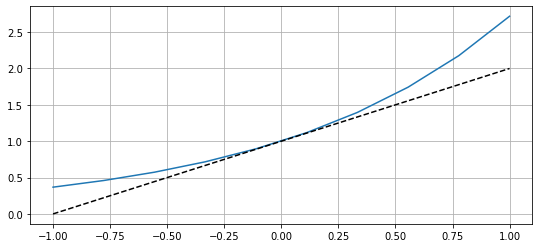

In [19]:
import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 10)
plt.plot(t, np.exp(t))
t = np.linspace(-1, 1, 2)
plt.plot(t,t+1, ls='--', c='k');

您可以看到斜率非常接近 $t=0.1$ 处的曲线，但离它很远
在 $t=1$。 但是，让我们继续步长为 1 的情况。 我们可以看到在 $t=1$ 时 $y$ 的估计值为 2。现在我们可以通过在 $t=1$ 处获取曲线的斜率并将其添加到我们的 初步估计。 斜率是用 $y'=y$ 计算的，所以斜率为 2。

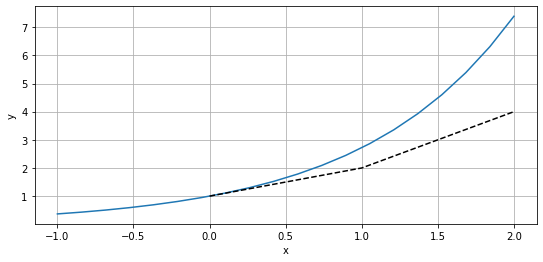

In [20]:
import kf_book.book_plots as book_plots

t = np.linspace(-1, 2, 20)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot([1, 2, 4], ls='--', c='k')
book_plots.set_labels(x='x', y='y');

在这里，我们看到 y 的下一个估计值是 4。误差很快就会变大，您可能不为所动。 但是 1 是一个非常大的步长。 让我们将此算法放入代码中，并通过使用小步长来验证它是否有效。

In [21]:
def euler(t, tmax, y, dx, step=1.):
    ys = []
    while t < tmax:
        y = y + step*dx(t, y)
        ys.append(y)
        t +=step        
    return ys

In [22]:
def dx(t, y): return y

print(euler(0, 1, 1, dx, step=1.)[-1])
print(euler(0, 2, 1, dx, step=1.)[-1])

2.0
4.0


这看起来是正确的。 所以现在让我们绘制一个小得多的步长的结果。

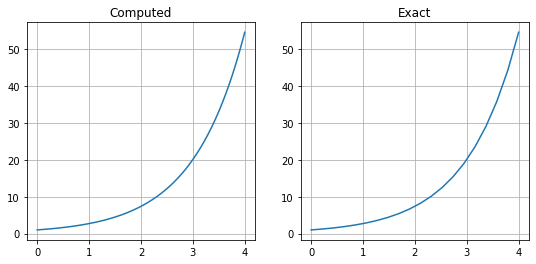

In [23]:
ys = euler(0, 4, 1, dx, step=0.00001)
plt.subplot(1,2,1)
plt.title('Computed')
plt.plot(np.linspace(0, 4, len(ys)),ys)
plt.subplot(1,2,2)
t = np.linspace(0, 4, 20)
plt.title('Exact')
plt.plot(t, np.exp(t));

In [24]:
print('exact answer=', np.exp(4))
print('euler answer=', ys[-1])
print('difference =', np.exp(4) - ys[-1])
print('iterations =', len(ys))

exact answer= 54.598150033144236
euler answer= 54.59705808834125
difference = 0.0010919448029866885
iterations = 400000


在这里，我们看到误差相当小，但需要大量的迭代才能获得三位数的精度。 在实践中，欧拉的方法对于大多数问题来说太慢了，我们使用更复杂的方法。

在继续之前，让我们正式推导出 Euler 方法，因为它是下一节中使用的更高级的 Runge Kutta 方法的基础。 事实上，欧拉方法是龙格库塔的最简单形式。


这是 $y$ 的泰勒展开式的前 3 项。 无限展开会给出准确的答案，因此 $O(h^4)$ 表示由于有限展开导致的误差。

$$y(t_0 + h) = y(t_0) + h y'(t_0) + \frac{1}{2!}h^2 y''(t_0) + \frac{1}{3!}h ^3 y'''(t_0) + O(h^4)$$

在这里我们可以看到欧拉的方法是使用泰勒展开式的前两项。 每个后续项都小于前一项，因此我们确信估计值不会与正确值相差太远。

### Runge Kutta Methods

Runge Kutta 是数值积分的主力军。 文献中有大量的方法。 在实践中，使用我在这里介绍的 Runge Kutta 算法将解决您将面临的大多数问题。 它在速度、精度和稳定性方面提供了非常好的平衡，并且它是“首选”数值积分方法，除非您有充分的理由选择不同的方法。

让我们开始吧。我们从一些微分方程开始

$$\ddot{y} = \frac{d}{dt}\dot{y}$$.

我们可以用函数 f 代替 y 的导数，就像这样

$$\ddot{y} = \frac{d}{dt}f(y,t)$$.

推导这些方程超出了本书的范围，但使用这些方程定义了 Runge Kutta RK4 方法。

$$y(t+\Delta t) = y(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(\Delta t^4)$$

$$\begin{aligned}
k_1 &= f(y,t)\Delta t \\
k_2 &= f(y+\frac{1}{2}k_1, t+\frac{1}{2}\Delta t)\Delta t \\
k_3 &= f(y+\frac{1}{2}k_2, t+\frac{1}{2}\Delta t)\Delta t \\
k_4 &= f(y+k_3, t+\Delta t)\Delta t
\end{aligned}
$$

下面是对应的代码：

In [25]:
def runge_kutta4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply 
    to compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

让我们用它来做一个简单的例子。 让

$$\dot{y} = t\sqrt{y(t)}$$

具有初始值

$$\begin{aligned}t_0 &= 0\\y_0 &= y(t_0) = 1\end{aligned}$$

max error 0.00005


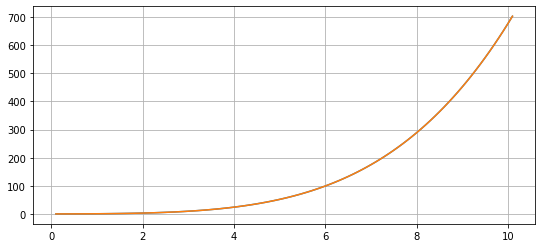

In [26]:
import math
import numpy as np
t = 0.
y = 1.
dt = .1

ys, ts = [], []

def func(y,t):
    return t*math.sqrt(y)

while t <= 10:
    y = runge_kutta4(y, t, dt, func)
    t += dt
    ys.append(y)
    ts.append(t)

exact = [(t**2 + 4)**2 / 16. for t in ts]
plt.plot(ts, ys)
plt.plot(ts, exact)

error = np.array(exact) - np.array(ys)
print(f"max error {max(error):.5f}")

## Bayesian Filtering

从离散贝叶斯一章开始，我使用贝叶斯公式进行过滤。假设我们正在跟踪一个对象。我们将它在特定时间的*状态*定义为它的位置、速度等。例如，我们可以将时间 $t$ 的状态写为 $\mathbf x_t = \begin{bmatrix}x_t &\dot x_t \end{bmatrix}^\mathsf T$。

当我们测量对象时，我们正在测量它的状态或部分。传感器有噪声，因此测量值被噪声破坏。显然，测量是由国家决定的。也就是说，状态的变化可能会改变测量，但测量的变化不会改变状态。

在过滤时，我们的目标是计算从时间 0 到时间 $t$ 的一组状态 $\mathbf x_{0:t}$ 的最优估计。如果我们知道 $\mathbf x_{0:t}$，那么计算一组对应于这些状态的测量值 $\mathbf z_{0:t}$ 将是微不足道的。但是，我们收到一组测量值 $\mathbf z_{0:t}$，并想要计算相应的状态 $\mathbf x_{0:t}$。这被称为*统计反演*，因为我们试图从输出中计算输入。

反演是一个难题，因为通常没有唯一的解决方案。对于给定的一组状态 $\mathbf x_{0:t}$，只有一组可能的测量值（加上噪声），但对于给定的一组测量值，有许多不同的状态组可能导致这些测量值.

回忆贝叶斯定理：

$$P(x \mid z) = \frac{P(z \mid x)P(x)}{P(z)}$$

其中 $P(z \mid x)$ 是测量 $z$ 的*似然性*，$P(x)$ 是基于我们的过程模型的*先验*，$P(z)$ 是归一化常数 . $P(x \mid z)$ 是*后验*，或合并测量 $z$ 后的分布，也称为*证据*。

这是一个*统计反转*，因为它从 $P(z \mid x)$ 到 $P(x \mid z)$。 我们的过滤问题的解决方案可以表示为：

$$P(\mathbf x_{0:t} \mid \mathbf z_{0:t}) = \frac{P(\mathbf z_{0:t} \mid \mathbf x_{0:t})P(\mathbf x_{0:t})}{P(\mathbf z_{0:t})}$$


这一切都很好，直到下一次测量 $\mathbf z_{t+1}$ 出现，此时我们需要重新计算范围 $0:t+1$ 的整个表达式。

在实践中，这是难以解决的，因为我们试图在整个时间步长范围内计算状态的后验分布 $P(\mathbf x_{0:t} \mid \mathbf z_{0:t})$。 但是当我们刚刚收到第十次测量时，我们真的关心第三步（比如说）的概率分布吗？ 通常不会。 所以我们放宽我们的要求，只计算当前时间步的分布。

第一个简化是我们将我们的过程（例如，移动物体的运动模型）描述为*马尔可夫链*。 也就是说，我们说当前状态完全依赖于前一个状态和一个转移概率$P(\mathbf x_k \mid \mathbf x_{k-1})$，也就是从上一个状态开始的概率 到现在的。 我们写：

$$\mathbf x_k \sim P(\mathbf x_k \mid \mathbf x_{k-1})$$

在实践中这是非常合理的，因为许多事物都具有*马尔可夫属性*。 如果你在停车场开车，你下一秒的位置是否取决于你是从州际公路上下来还是在一分钟前在土路上爬行？ 不，你下一秒的位置完全取决于你当前的位置、速度和控制输入，而不是一分钟前发生的事情。 因此，汽车具有马尔可夫性质，我们可以在不损失精确性或一般性的情况下进行这种简化。

我们进行的下一个简化是确实将*测量模型*定义为取决于当前状态 $\mathbf x_k$ 以及给定当前状态的测量条件概率：$P(\mathbf z_t \mid \mathbf x_x)$。 我们写：

$$\mathbf z_k \sim P(\mathbf z_t \mid \mathbf x_x)$$

我们现在有一个递归，所以我们需要一个初始条件来终止它。 因此我们说初始分布是状态 $\mathbf x_0$ 的概率：

$$\mathbf x_0 \sim P(\mathbf x_0)$$

这些项被插入贝叶斯方程。如果我们有状态 $\mathbf x_0$ 和第一次测量，我们可以估计 $P(\mathbf x_1 | \mathbf z_1)$。运动模型创建了先验 $P(\mathbf x_2 \mid \mathbf x_1)$。我们将其反馈给贝叶斯定理以计算 $P(\mathbf x_2 | \mathbf z_2)$。我们继续这种预测-校正算法，仅基于时间 $t-1$ 的状态和分布以及时间 $t$ 的测量值递归地计算时间 $t$ 的状态和分布。

此计算的数学细节因问题而异。 **离散贝叶斯**和**单变量卡尔曼滤波器**章节给出了两种不同的公式，你应该能够推理出来。单变量卡尔曼滤波器假设对于标量状态，噪声和过程都是线性模型，均受零均值、不相关的高斯噪声影响。

多元卡尔曼滤波器做出相同的假设，但状态和测量是向量，而不是标量。卡尔曼博士能够证明，如果这些假设成立，那么卡尔曼滤波器在最小二乘意义上是*最优的。通俗地说，这意味着无法从噪声测量中获得更多信息。在本书的其余部分，我将介绍放松对线性和高斯噪声约束的滤波器。

在继续之前，我还要多说几句关于统计反演的内容。正如 Calvetti 和 Somersalo 在*贝叶斯科学计算简介*中所写，“我们采用贝叶斯观点：*随机性只是意味着缺乏信息*。”[3] 我们的状态参数化了我们原则上可以测量或计算的物理现象：速度、空气阻力等。我们缺乏足够的信息来计算或测量它们的值，因此我们选择将它们视为随机变量。严格来说它们不是随机的，因此这是一个主观的立场。

他们用一整章的篇幅来讨论这个主题。我可以留一段。贝叶斯过滤器是可能的，因为我们将统计属性归因于未知参数。在卡尔曼滤波器的情况下，我们有封闭形式的解决方案来找到最佳估计。其他过滤器，例如离散贝叶斯过滤器或我们在后面章节中介绍的粒子过滤器，以一种更加特别的、非最优的方式对概率进行建模。我们技术的强大之处在于将缺乏信息视为随机变量，将该随机变量描述为概率分布，然后使用贝叶斯定理解决统计推断问题。

## Converting Kalman Filter to a g-h Filter

我已经说过卡尔曼滤波器是 g-h 滤波器的一种形式。 只需要一些代数来证明它。 使用一维情况更简单，所以我会这样做。 记起

$$
\mu_{x}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$


我会让我们的眼睛更友好：

$$
\mu_{x}=\frac{ya + xb} {a+b}
$$

我们可以使用以下代数轻松将其转换为 g-h 形式

$$
\begin{aligned}
\mu_{x}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

我们几乎完成了，但请记住，估计的方差由下式给出

$$\begin{aligned}
\sigma_{x}^2 &= \frac{1}{\frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}} \\
&= \frac{1}{\frac{1}{a} +  \frac{1}{b}}
\end{aligned}$$

我们差不多完成了，但请记住估计的方差由下式给出

$$ 
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}  \\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}  \\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x'}}{b}
 \end{aligned}
$$

我们可以将所有这些联系在一起

$$
\begin{aligned}
\mu_{x}&=x+ \frac{a}{a+b}(y-x) \\
&= x + \frac{\sigma^2_{x'}}{b}(y-x) \\
&= x + g_n(y-x)
\end{aligned}
$$

其中

$$g_n = \frac{\sigma^2_{x}}{\sigma^2_{y}}$$

最终结果是将两个测量值的残差乘以一个常数并添加到我们之前的值，即 g-h 滤波器的 $g$ 方程。 $g$ 是新估计的方差除以测量的方差。 当然，在这种情况下，$g$ 不是一个常数，因为它随着方差的变化而随着每个时间步长而变化。 我们也可以用同样的方法推导出 $h$ 的公式。 这不是一个特别有启发性的推导，我将跳过它。 最终结果是

$$h_n = \frac{COV (x,\dot x)}{\sigma^2_{y}}$$

要点是 $g$ 和 $h$ 完全由时间 $n$ 的测量和预测的方差和协方差指定。 换句话说，我们通过由这两个输入中的每一个的质量确定的比例因子在测量和预测之间选择一个点。


## References

 * [1] C.B. Molwer and C.F. Van Loan "Nineteen Dubious Ways to Compute the Exponential of a Matrix, Twenty-Five Years Later,", *SIAM Review 45, 3-49*. 2003.


 * [2] C.F. van Loan, "Computing Integrals Involving the Matrix Exponential," IEEE *Transactions Automatic Control*, June 1978.
 
 
 * [3] Calvetti, D and Somersalo E, "Introduction to Bayesian Scientific Computing: Ten Lectures on Subjective Computing,", *Springer*, 2007.
 
 * [4] Brown, R. G. and Hwang, P. Y.C., "Introduction to Random Signals and Applied Kalman Filtering", *Wiley and Sons*, Fourth Edition, p.143-147, 2012. 